In [29]:
!pip install Wikipedia-API -q

  Preparing metadata (setup.py) ... done


In [30]:
import wikipediaapi, re
import requests, os, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- Class Definitions from your script ---

class Config():
    def __init__(self, mode, data_dir):
        self.BASE_LINK = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{topic_name}/daily/{start_time}/{end_time}"
        # Yesterday's timestamp
        if mode=="training":
            self.start_date = "2015010100" # Changed to 2015 to match our original plan
            self.end_date = (datetime.today() - timedelta(days=1)).strftime("%Y%m%d00")
        else:
            # This 'else' block is perfect for your Phase 3 pipeline
            self.start_date = (datetime.today() - timedelta(days=7)).strftime("%Y%m%d00")
            self.end_date = (datetime.today() - timedelta(days=1)).strftime("%Y%m%d00")
        
        os.makedirs(data_dir, exist_ok=True)
        self.headers = {
            "User-Agent": "BTechEventDetector/1.0 (B.Tech Final Year Project; contact@example.com)"
        }
        self.data_dir = Path(data_dir)

class FetchData:
    def __init__(self, mode="training", data_dir="./data", category="Influenza"):
        self.category = category
        self.wiki = wikipediaapi.Wikipedia(
            user_agent="BTechEventDetector/1.0 (B.Tech Final Year Project; contact@example.com)",
            language="en"
        )
        self.config = Config(mode=mode, data_dir=data_dir)
        self.DATA_DIR = Path(data_dir)
    
    def _call_api(self, topic):
        print(f"Getting data for: {topic}")
        # Format topic name for URL (replace spaces with underscores)
        topic_url = topic.replace(' ', '_')
        page_link = self.config.BASE_LINK.format(topic_name=topic_url, start_time=self.config.start_date, end_time=self.config.end_date)
        
        # Format topic name for file (replace / with _)
        file_name = topic.replace(' ', '_').replace('/', '_')
        file_path = self.config.data_dir / f"{file_name}_pageviews_{self.config.end_date}.json"

        try:
            response = requests.get(page_link, headers=self.config.headers)
            response.raise_for_status()
            
            with open(file_path, "w") as f:
                json.dump(response.json(), f, indent=2)
            
            # Optional: Log the last view count
            # last_view = response.json().get("items", [{}])[-1].get("views", 0)
            # print(f"  ... success. Last day views: {last_view}")

        except requests.exceptions.RequestException as e:
            print(f"  ... FAILED for {topic}: {e}")
            # Handle 404 Not Found specifically
            if e.response and e.response.status_code == 404:
                print(f"  ... Article '{topic}' (URL: {topic_url}) not found in pageviews API.")


    def get_pageviews(self, topics=[]):
        for topic in topics:
            self._call_api(topic=topic)
        print("Fetching completed.")

    def get_topics_from_cat(self, limit=50, max_depth=1, min_length=2000, min_backlinks=10):
            visited_categories = set()
            topics_data = []

            def recurse_category(cat_page, current_depth):
                if current_depth > max_depth or cat_page.title in visited_categories:
                    return

                visited_categories.add(cat_page.title)

                for member in cat_page.categorymembers.values():
                    # Only process main articles and subcategories
                    if member.ns == wikipediaapi.Namespace.MAIN:
                        page = self.wiki.page(member.title)
                        if not page.exists(): continue # Skip broken links
                        
                        content = page.text
                        length = len(content)
                        backlinks_count = len(page.backlinks)
                        has_infobox = bool(re.search(r"\{\{Infobox", content, re.IGNORECASE))

                        # Apply relevance filters
                        if length < min_length or backlinks_count < min_backlinks:
                            continue

                        relevance_score = length + backlinks_count * 100
                        if has_infobox:
                            relevance_score *= 1.2

                        topics_data.append((member.title, relevance_score))
                        print(f"  Found: {member.title} | len={length} | backlinks={backlinks_count} | infobox={has_infobox}")

                    elif member.ns == wikipediaapi.Namespace.CATEGORY and current_depth < max_depth:
                        # Recursively explore subcategories
                        recurse_category(member, current_depth + 1)

            start_category = self.wiki.page(f"Category:{self.category}")
            if not start_category.exists():
                print(f"Category '{self.category}' not found.")
                return []

            print(f"Scanning category '{self.category}' (max_depth={max_depth})...")
            recurse_category(start_category, 0)

            if not topics_data:
                print(f"No relevant topics found under '{self.category}'.")
                return []

            # Sort by relevance and limit results
            topics_data.sort(key=lambda x: x[1], reverse=True)
            final_topics = [title for title, _ in topics_data]

            print(f"\nFetched {len(final_topics)} relevant topics from '{self.category}'.")
            return final_topics[:limit]

print("Classes and imports loaded.")

Classes and imports loaded.


In [31]:
# 1. Define the data directory and category
DATA_DIR = "./data"
DOMAIN_CATEGORY = "Influenza"
ARTICLE_LIMIT = 50 # As per your project spec

# 2. Instantiate the fetcher
fetcher = FetchData(mode="training", data_dir=DATA_DIR, category=DOMAIN_CATEGORY)

# 3. Get the top N topics from the category
print(f"--- Finding Top {ARTICLE_LIMIT} Articles for '{DOMAIN_CATEGORY}' ---")
topics = fetcher.get_topics_from_cat(limit=ARTICLE_LIMIT, max_depth=1)
print(f"\nSelected Topics: {topics}")

# 4. Download all pageview data for these topics
print(f"\n--- Fetching Pageview Data (2015-Yesterday) ---")
fetcher.get_pageviews(topics=topics)

print("\n--- Data downloading complete. Files are in './data' ---")

--- Finding Top 50 Articles for 'Influenza' ---
Scanning category 'Influenza' (max_depth=1)...
  Found: Influenza | len=65822 | backlinks=4255 | infobox=False
  Found: Antigenic drift | len=5544 | backlinks=163 | infobox=False
  Found: Antigenic shift | len=3930 | backlinks=199 | infobox=False
  Found: Betainfluenzavirus | len=10178 | backlinks=196 | infobox=False
  Found: Canine influenza | len=8267 | backlinks=196 | infobox=False
  Found: Equine influenza | len=12083 | backlinks=245 | infobox=False
  Found: Evolution of influenza | len=65822 | backlinks=4255 | infobox=False
  Found: Flu season | len=15324 | backlinks=294 | infobox=False
  Found: Flurona | len=2586 | backlinks=1835 | infobox=False
  Found: GISAID | len=14352 | backlinks=210 | infobox=False
  Found: Global Influenza Surveillance and Response System | len=2896 | backlinks=18 | infobox=False
  Found: Google Flu Trends | len=9234 | backlinks=649 | infobox=False
  Found: Influenza B virus | len=10178 | backlinks=196 | info

In [39]:
all_pageviews_data = []
data_path = Path(DATA_DIR)

print(f"Loading files from {data_path.resolve()}...")

# 1. Find all downloaded JSON files
json_files = list(data_path.glob("*.json"))
if not json_files:
    print("Error: No JSON files found. Did Step 2 run correctly?")

# 2. Loop through each file, load it, and parse the data
for file in json_files:
    try:
        with open(file, 'r') as f:
            data = json.load(f)
        
        # Extract each day's data from the "items" list
        if 'items' in data:
            for item in data['items']:
                all_pageviews_data.append({
                    'time_stamp_str': item['timestamp'],
                    'article_name': item['article'].replace('_', ' '), # Store with spaces
                    'pageviews': item['views']
                })
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# 3. Create the master DataFrame (same as our old Step 5)
df = pd.DataFrame(all_pageviews_data)

if df.empty:
    print("No data was loaded. DataFrame is empty. Please check file paths and JSON content.")
else:
    # 4. Clean the data
    df['time_stamp'] = pd.to_datetime(df['time_stamp_str'], format='%Y%m%d%H')
    df = df.set_index('time_stamp')
    
    # Store the final, cleaned master DataFrame
    df_master = df[['article_name', 'pageviews']]
    
    print("Master DataFrame created successfully.")
    print("\n--- DataFrame Info ---")
    df_master.info()
    
    print("\n--- DataFrame Head ---")
    print(df_master.head())

Loading files from /kaggle/working/data...
Master DataFrame created successfully.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 162391 entries, 2015-07-01 to 2025-10-30
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   article_name  162391 non-null  object
 1   pageviews     162391 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB

--- DataFrame Head ---
               article_name  pageviews
time_stamp                            
2015-07-01  Simin Daneshvar         25
2015-07-02  Simin Daneshvar         30
2015-07-03  Simin Daneshvar         54
2015-07-04  Simin Daneshvar         48
2015-07-05  Simin Daneshvar         27


In [33]:
# def fetch_pageviews(article_title, start, end):
#     """
#     Fetches daily pageviews for a single Wikipedia article.
#     """
#     # Replace spaces with underscores for the API URL
#     article_formatted = article_title.replace(' ', '_')
    
#     URL_TEMPLATE = (
#         "https"
#         "://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/"
#         "en.wikipedia/all-access/all-agents/{article}/daily/{start}/{end}"
#     )
    
#     url = URL_TEMPLATE.format(
#         article=article_formatted,
#         start=start,
#         end=end
#     )
    
#     try:
#         response = requests.get(url, headers=HEADERS)
#         response.raise_for_status() # Raises an exception for bad status codes (4xx or 5xx)
#         return response.json()
    
#     except requests.exceptions.RequestException as e:
#         print(f"Error fetching data for '{article_title}': {e}")
#         return None

# # --- Test the function with one article ---
# print("Testing fetch function...")
# test_data = fetch_pageviews("Influenza", "2024010100", "2024010700")

# if test_data and 'items' in test_data:
#     print(f"Successfully fetched {len(test_data['items'])} days of data for 'Influenza'.")
#     # print(test_data['items'][0]) # Uncomment to see example item
# else:
#     print("Test fetch failed.")

Testing fetch function...
Successfully fetched 7 days of data for 'Influenza'.


In [34]:
# all_pageviews_data = []

# print(f"Starting data extraction for {len(article_corpus)} articles...")

# for i, article in enumerate(article_corpus):
#     print(f"({i+1}/{len(article_corpus)}) Fetching: {article}...")
    
#     data = fetch_pageviews(article, START_DATE, END_DATE)
    
#     if data and 'items' in data:
#         # The API returns a list of daily data points
#         for item in data['items']:
#             all_pageviews_data.append({
#                 'time_stamp_str': item['timestamp'],
#                 'article_name': item['article'].replace('_', ' '), # Store with spaces
#                 'pageviews': item['views']
#             })
            
#     # Be polite to the API: wait half a second between requests
#     time.sleep(0.5)

# print("\nData extraction complete.")
# print(f"Total data points fetched: {len(all_pageviews_data)}")

Starting data extraction for 14 articles...
(1/14) Fetching: Influenza...
(2/14) Fetching: Oseltamivir...
(3/14) Fetching: Flu_season...
(4/14) Fetching: Pandemic...
(5/14) Fetching: Influenza_A_virus...
(6/14) Fetching: Influenza_B_virus...
(7/14) Fetching: Avian_influenza...
(8/14) Fetching: Swine_influenza...
(9/14) Fetching: Influenza_vaccine...
(10/14) Fetching: Antiviral_drugs...
(11/14) Fetching: Fever...
(12/14) Fetching: Cough...
(13/14) Fetching: Spanish_flu...
(14/14) Fetching: Influenza_prevention...

Data extraction complete.
Total data points fetched: 48576


In [35]:
# # 1. Create the DataFrame
# df = pd.DataFrame(all_pageviews_data)

# if df.empty:
#     print("No data was fetched. DataFrame is empty. Please check API calls.")
# else:
#     # 2. Clean the data
#     # Convert timestamp string to a proper datetime object
#     # The '00' at the end represents the hour, so we can parse it
#     df['time_stamp'] = pd.to_datetime(df['time_stamp_str'], format='%Y%m%d%H')
    
#     # Set the timestamp as the index, which is best practice for time-series
#     df = df.set_index('time_stamp')
    
#     # Select and order the columns as per your schema
#     df_master = df[['article_name', 'pageviews']]
    
#     # 3. Display results
#     print("Master DataFrame created successfully.")
#     print("\n--- DataFrame Info ---")
#     df_master.info()
    
#     print("\n--- DataFrame Head ---")
#     print(df_master.head())
    
#     print("\n--- DataFrame Tail ---")
#     print(df_master.tail())
    
#     print("\n--- Example: Pageviews for 'Influenza' ---")
#     print(df_master[df_master['article_name'] == 'Influenza'].head())

Master DataFrame created successfully.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48576 entries, 2015-07-01 to 2024-12-31
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_name  48576 non-null  object
 1   pageviews     48576 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB

--- DataFrame Head ---
           article_name  pageviews
time_stamp                        
2015-07-01    Influenza       2693
2015-07-02    Influenza       3025
2015-07-03    Influenza       2185
2015-07-04    Influenza       1944
2015-07-05    Influenza       2609

--- DataFrame Tail ---
                    article_name  pageviews
time_stamp                                 
2024-12-27  Influenza prevention          6
2024-12-28  Influenza prevention         12
2024-12-29  Influenza prevention         12
2024-12-30  Influenza prevention          9
2024-12-31  Influenza prevention     

In [47]:
if 'df_master' not in locals() or df_master.empty:
    print("Error: 'df_master' not found or is empty. Please run Step 3.")
else:
    # 1. Define parameters
    ROLLING_WINDOW_30D = 30
    ROLLING_WINDOW_7D = 7
    Z_SCORE_THRESHOLD = 2.0  # Keep the high-recall threshold

    print(f"--- Generating labels (Z > {Z_SCORE_THRESHOLD}) and RATIO features ---")

    df_labeled = df_master.copy()
    all_processed_dfs = []

    # 2. Calculate features and labels for each article
    for article in df_labeled['article_name'].unique():
        
        df_article = df_labeled[df_labeled['article_name'] == article].copy()
        
        # 3. Create contextual features
        df_article['rolling_mean_30d'] = df_article['pageviews'].rolling(window=ROLLING_WINDOW_30D, min_periods=1).mean()
        df_article['rolling_std_30d'] = df_article['pageviews'].rolling(window=ROLLING_WINDOW_30D, min_periods=1).std()
        df_article['rolling_mean_7d'] = df_article['pageviews'].rolling(window=ROLLING_WINDOW_7D, min_periods=1).mean()

        # 4. --- NEW RATIO FEATURES ---
        # Calculate ratio of pageviews to the rolling means
        # We add 1 to the denominator to avoid division by zero (for days with 0 mean views)
        df_article['ratio_to_30d_mean'] = df_article['pageviews'] / (df_article['rolling_mean_30d'] + 1)
        df_article['ratio_to_7d_mean'] = df_article['pageviews'] / (df_article['rolling_mean_7d'] + 1)
        
        # 5. Create the label
        df_article['z_score'] = (df_article['pageviews'] - df_article['rolling_mean_30d']) / df_article['rolling_std_30d']
        df_article['z_score'] = df_article['z_score'].replace([np.inf, -np.inf], 0).fillna(0)
        df_article['is_abnormal'] = (df_article['z_score'] > Z_SCORE_THRESHOLD).astype(int)
        
        all_processed_dfs.append(df_article)

    # 6. Recombine and clean
    df_labeled = pd.concat(all_processed_dfs)
    df_labeled = df_labeled.sort_index()
    df_labeled = df_labeled.fillna(0)
    
    # We can now drop the columns we used to build the features/labels
    df_labeled = df_labeled.drop(columns=['z_score', 'rolling_mean_30d', 'rolling_std_30d', 'rolling_mean_7d'])

    print("--- Labeled DataFrame with new RATIO features created ---")
    print(f"Total abnormal labels: {df_labeled['is_abnormal'].sum()}")
    print(df_labeled.head())

--- Generating labels (Z > 2.0) and RATIO features ---
--- Labeled DataFrame with new RATIO features created ---
Total abnormal labels: 7609
                                       article_name  pageviews  \
time_stamp                                                       
2015-07-01                          Simin Daneshvar         25   
2015-07-01                        Google Flu Trends         34   
2015-07-01                        Influenza A virus        622   
2015-07-01      Princess Louise Margaret of Prussia        106   
2015-07-01  National Institute for Medical Research         36   

            ratio_to_30d_mean  ratio_to_7d_mean  is_abnormal  
time_stamp                                                    
2015-07-01           0.961538          0.961538            0  
2015-07-01           0.971429          0.971429            0  
2015-07-01           0.998395          0.998395            0  
2015-07-01           0.990654          0.990654            0  
2015-07-01        

In [48]:
# Create a new DataFrame for modeling
df_model = df_labeled.copy()

# 1. Create time-based features
df_model['day_of_year'] = df_model.index.dayofyear
df_model['month'] = df_model.index.month
df_model['day_of_week'] = df_model.index.dayofweek

# 2. Encode 'article_name'
df_model['article_name'] = df_model['article_name'].astype('category')
df_model['article_code'] = df_model['article_name'].cat.codes

# 3. --- NEW RATIO FEATURE SET ---
# We are now using the ratios, which are much stronger signals.
# We keep 'pageviews' as it's still a useful measure of magnitude.
features = [
    'pageviews',
    'ratio_to_30d_mean', # NEW
    'ratio_to_7d_mean',  # NEW
    'day_of_year',
    'month',
    'day_of_week',
    'article_code'
]

target = 'is_abnormal'

X = df_model[features]
y = df_model[target]

print(f"Training with {len(features)} features (including ratios).")
print(X.head())

Training with 7 features (including ratios).
            pageviews  ratio_to_30d_mean  ratio_to_7d_mean  day_of_year  \
time_stamp                                                                
2015-07-01         25           0.961538          0.961538          182   
2015-07-01         34           0.971429          0.971429          182   
2015-07-01        622           0.998395          0.998395          182   
2015-07-01        106           0.990654          0.990654          182   
2015-07-01         36           0.972973          0.972973          182   

            month  day_of_week  article_code  
time_stamp                                    
2015-07-01      7            2            41  
2015-07-01      7            2            19  
2015-07-01      7            2            22  
2015-07-01      7            2            36  
2015-07-01      7            2            34  


Training data shape: (131390, 7)
Testing data shape:  (31001, 7)
Test set 'abnormal' count: 1605

Training model on new 50-article dataset...
Model training complete.

--- Model Evaluation on Test Set (2024) ---
              precision    recall  f1-score   support

  Normal (0)       0.99      0.99      0.99     29396
Abnormal (1)       0.79      0.76      0.77      1605

    accuracy                           0.98     31001
   macro avg       0.89      0.87      0.88     31001
weighted avg       0.98      0.98      0.98     31001

--- Confusion Matrix ---


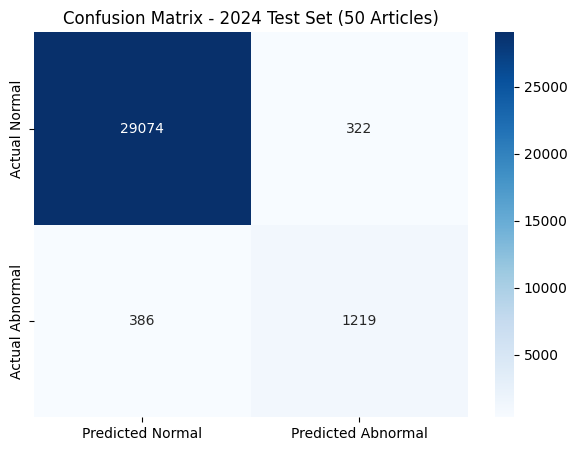

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Split data chronologically
split_date = '2024-01-01'

X_train = X[X.index < split_date]
y_train = y[y.index < split_date]

X_test = X[X.index >= split_date]
y_test = y[y.index >= split_date]

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape:  {X_test.shape}")
print(f"Test set 'abnormal' count: {y_test.sum()}")

# 2. Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

print("\nTraining model on new 50-article dataset...")
model.fit(X_train, y_train)
print("Model training complete.")

# 3. Evaluate the model
print("\n--- Model Evaluation on Test Set (2024) ---")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Abnormal (1)']))

# 4. Plot Confusion Matrix
print("--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Normal', 'Predicted Abnormal'], 
            yticklabels=['Actual Normal', 'Actual Abnormal'])
plt.title(f'Confusion Matrix - 2024 Test Set ({ARTICLE_LIMIT} Articles)')
plt.show()

In [52]:
import joblib

# 1. Save the trained model
MODEL_FILE = 'domain_event_model.joblib'
joblib.dump(model, MODEL_FILE)

print(f"Model saved to: {MODEL_FILE}")

# 2. Save the article name to code mappings
# We need this so the new script knows 'Influenza' = 12 (or similar)
# We save the 'categories' which is the lookup list
article_categories = df_model['article_name'].cat.categories
MAPPINGS_FILE = 'article_mappings.joblib'
joblib.dump(article_categories, MAPPINGS_FILE)

print(f"Article mappings saved to: {MAPPINGS_FILE}")

# 3. We also need to save the master list of articles to monitor
ARTICLE_LIST_FILE = 'article_corpus.json'
# Get the unique list of names from the DataFrame
article_corpus_list = list(df_master['article_name'].unique())
with open(ARTICLE_LIST_FILE, 'w') as f:
    json.dump(article_corpus_list, f)
    
print(f"Article corpus list saved to: {ARTICLE_LIST_FILE}")

Model saved to: domain_event_model.joblib
Article mappings saved to: article_mappings.joblib
Article corpus list saved to: article_corpus.json
